# Internet Traffic Prediction

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("Website Vistiors Daywise - Sheet1.csv")
data.head()

,Date,Daily Visitors
0,01-10-2021,2649
1,02-10-2021,2000
2,03-10-2021,2011
3,04-10-2021,3219
4,05-10-2021,3870


In [3]:
data.dtypes

Date              object
Daily Visitors     int64
dtype: object

In [4]:
data['Date'] = pd.to_datetime(data['Date'],format='%d-%m-%Y')

In [5]:
data.shape

(173, 2)

In [6]:
data.describe()

,Daily Visitors
count,173.000000
mean,2829.907514
std,765.194741
min,1245.000000
25%,2336.000000
50%,2751.000000
75%,3207.000000
max,7165.000000


# Data Preprocessing

In [7]:
data.isna().sum()

Date              0
Daily Visitors    0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            173 non-null    datetime64[ns]
 1   Daily Visitors  173 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [9]:
data.head()

,Date,Daily Visitors
0,2021-10-01,2649
1,2021-10-02,2000
2,2021-10-03,2011
3,2021-10-04,3219
4,2021-10-05,3870



# Data Exploration(EDA)

In [10]:
data_feat = pd.DataFrame({"year": data['Date'].dt.year,
                          "month": data['Date'].dt.month,
                          "day": data['Date'].dt.day,
                          "dayofyear": data['Date'].dt.dayofyear,
                          "week": data['Date'].dt.week,
                          "weekday": data['Date'].dt.dayofweek,
                          "quarter": data['Date'].dt.quarter,
                         })
data_feat.head()

,year,month,day,dayofyear,week,weekday,quarter
0,2021,10,1,274,39,4,4
1,2021,10,2,275,39,5,4
2,2021,10,3,276,39,6,4
3,2021,10,4,277,40,0,4
4,2021,10,5,278,40,1,4


In [11]:
complete_data = pd.concat([data_feat, data['Daily Visitors']], axis=1)
complete_data.head()

,year,month,day,dayofyear,week,weekday,quarter,Daily Visitors
0,2021,10,1,274,39,4,4,2649
1,2021,10,2,275,39,5,4,2000
2,2021,10,3,276,39,6,4,2011
3,2021,10,4,277,40,0,4,3219
4,2021,10,5,278,40,1,4,3870


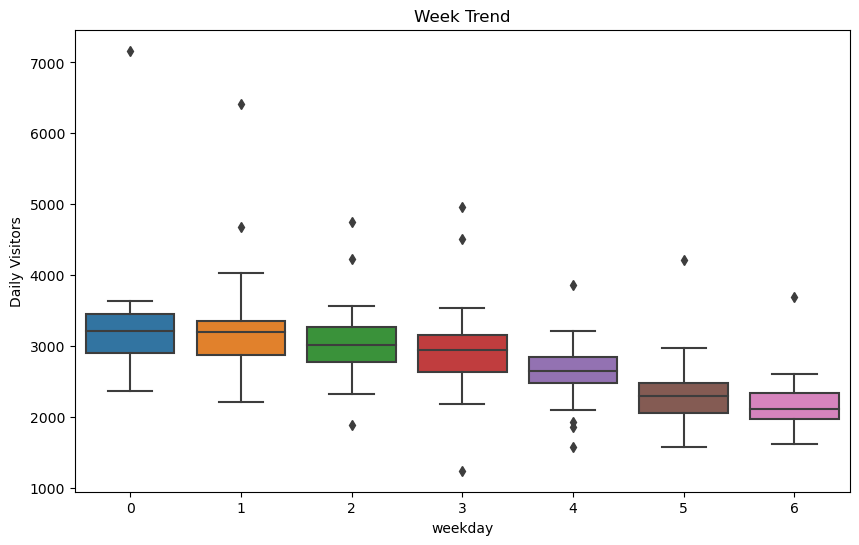

In [12]:
#boxplot for week's count
plt.figure(figsize=(10,6))
sns.boxplot(x=complete_data['weekday'], y=complete_data['Daily Visitors'], )
plt.title('Week Trend')
plt.show()

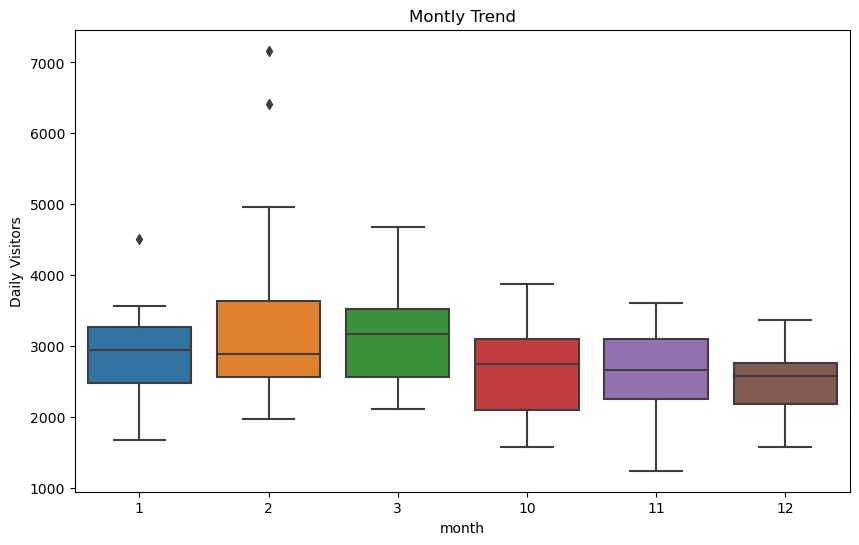

In [13]:
# boxplot for month's count
plt.figure(figsize=(10,6))
sns.boxplot(x=complete_data['month'], y=complete_data['Daily Visitors'], )
plt.title('Montly Trend')
plt.show()

In [14]:

#check the average for each quarter.
quarter_average = pd.DataFrame(complete_data.groupby('quarter')['Daily Visitors'].mean())
quarter_average

,Daily Visitors
quarter,
1,3089.790123
4,2601.097826


<Axes: xlabel='year'>

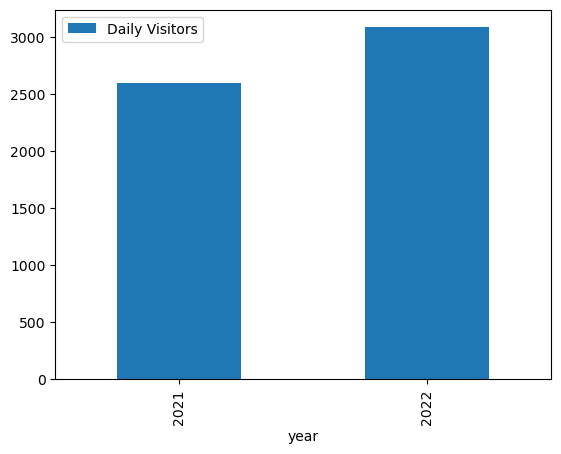

In [15]:
yearly_average = pd.DataFrame(complete_data.groupby('year')['Daily Visitors'].mean())
yearly_average
yearly_average.plot(kind='bar')

In [16]:
data.loc[data["Daily Visitors"]>=4500]

,Date,Daily Visitors
111,2022-01-20,4509
144,2022-02-22,6407
145,2022-02-23,4751
146,2022-02-24,4961
150,2022-02-28,7165
151,2022-03-01,4687


In [17]:
Q1=data['Daily Visitors'].quantile(0.25)
Q1

2336.0

In [18]:
Q3=data['Daily Visitors'].quantile(0.75)
Q3

3207.0

In [19]:
# Inter-quartile range
IQR=Q3-Q1
print(f"inter-Quartile Range: {IQR}")

inter-Quartile Range: 871.0


In [20]:
#lower_limit,upper_limit

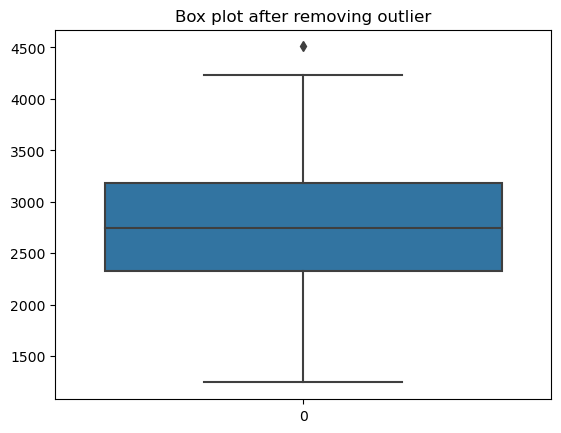

In [21]:
# Box plot after removing outlier

def drop_outlier(data):
    
    IQR=1.5*(np.percentile(data["Daily Visitors"],75)-np.percentile(data["Daily Visitors"],25))
    data.drop(data[data["Daily Visitors"]>(IQR+np.percentile(data["Daily Visitors"],75))].index,inplace=True)
    data.drop(data[data["Daily Visitors"]<(np.percentile(data["Daily Visitors"],25)-IQR)].index,inplace=True)
       
drop_outlier(data)
sns.boxplot(data["Daily Visitors"])
plt.title("Box plot after removing outlier")
plt.show()
    
        

In [22]:
data.shape

(168, 2)

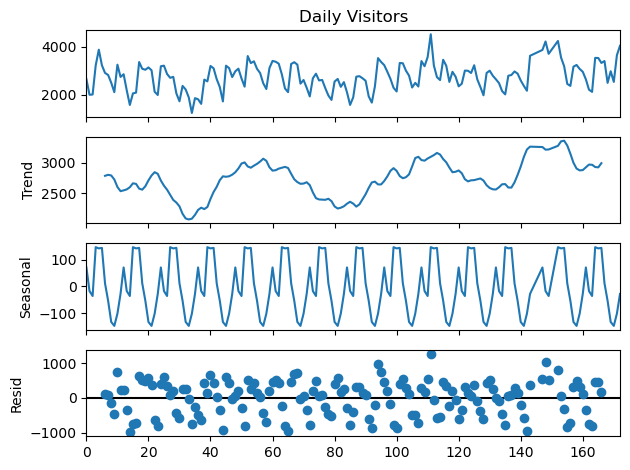

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(data["Daily Visitors"],period=12)
decompose_ts_add.plot()
plt.show()

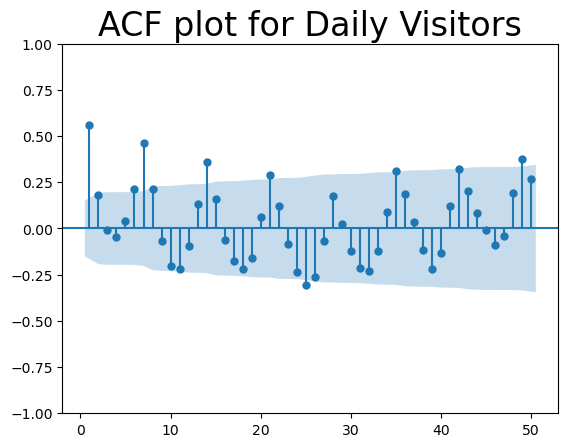

In [24]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(data["Daily Visitors"],lags=50,zero=False)
plt.title("ACF plot for Daily Visitors",size=24)
plt.show()

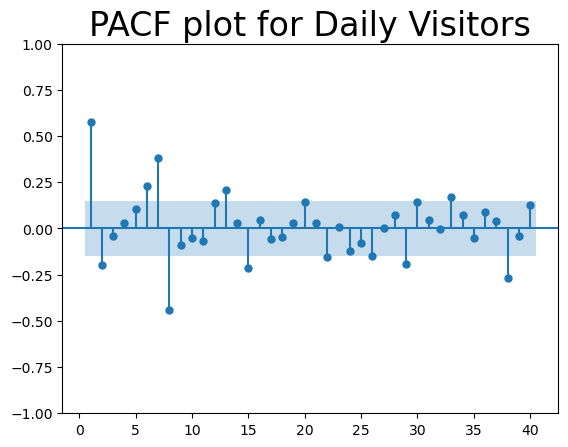

In [25]:


sgt.plot_pacf(data["Daily Visitors"],lags=40,zero=False,method=("ols"))
plt.title("PACF plot for Daily Visitors",size=24)
plt.show()


# Test for stationarity or Data

## ADF Test

In [26]:

from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result=adfuller(series.dropna())
    if result[1]<=0.05:
        print("Reject the Null Hypothesis")
        print("Data is Sattionary")
    else:
        print("Fail to reject the Null Hypothesis")
        print("Data is Non-Sattionary")

In [27]:
adf_test(data["Daily Visitors"])

Fail to reject the Null Hypothesis
Data is Non-Sattionary


# KPSS Test

In [28]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(data["Daily Visitors"])

KPSS Statistic: 0.5473300113365421
p-value: 0.031006754203481496
num lags: 5
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


#### KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

# Detrending the data

In [29]:
rolling = data["Daily Visitors"].rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head())
data1 = pd.DataFrame(rolling_mean.dropna())
data.head()

0            NaN
1            NaN
2    2220.000000
3    2410.000000
4    3033.333333
Name: Daily Visitors, dtype: float64


,Date,Daily Visitors
0,2021-10-01,2649
1,2021-10-02,2000
2,2021-10-03,2011
3,2021-10-04,3219
4,2021-10-05,3870


### Detrending is carried out by using rolling mean. Trend stationary time series is converted into strict stationary time series. 

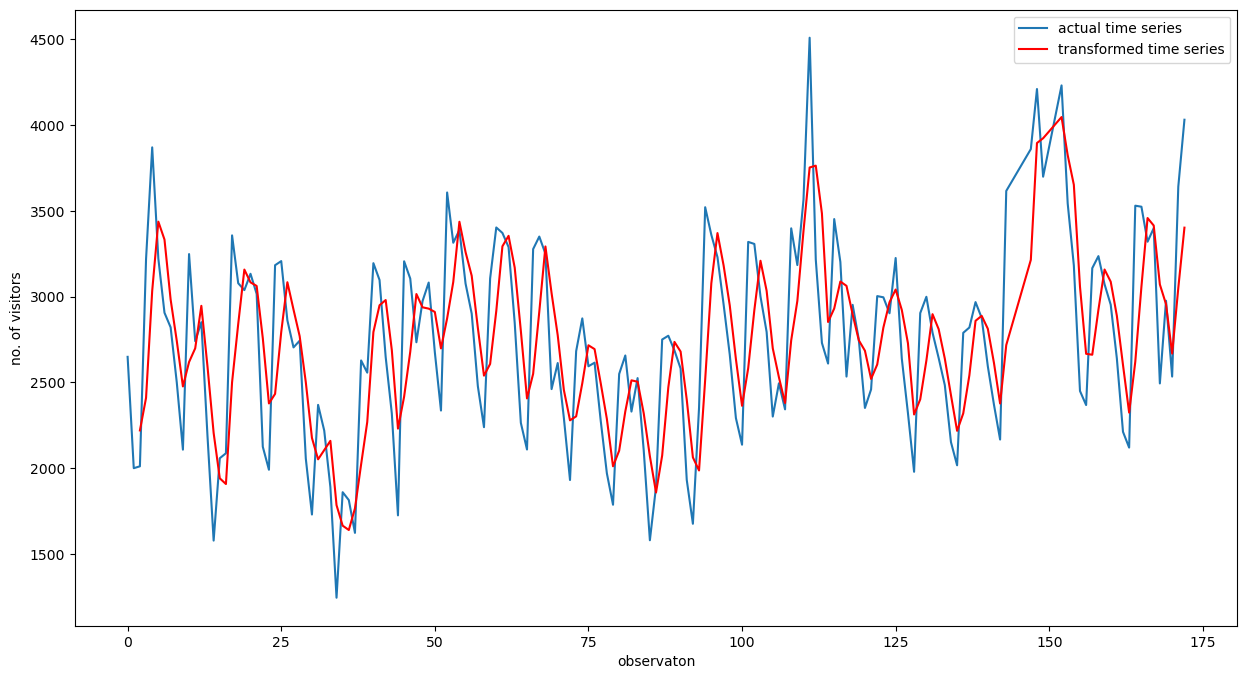

In [31]:
# Comparing the after and before versions of time series

plt.figure(figsize=(15,8))
data["Daily Visitors"].plot()
data1["Daily Visitors"].plot(color='red')
plt.legend(['actual time series','transformed time series'])
plt.ylabel("no. of visitors")
plt.xlabel("observaton")
plt.show()

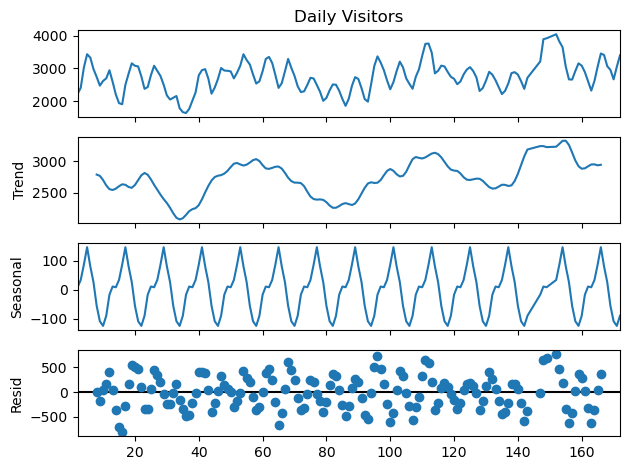

In [32]:
decompose_ts_add = seasonal_decompose(data1["Daily Visitors"],period=12)
decompose_ts_add.plot()
plt.show()

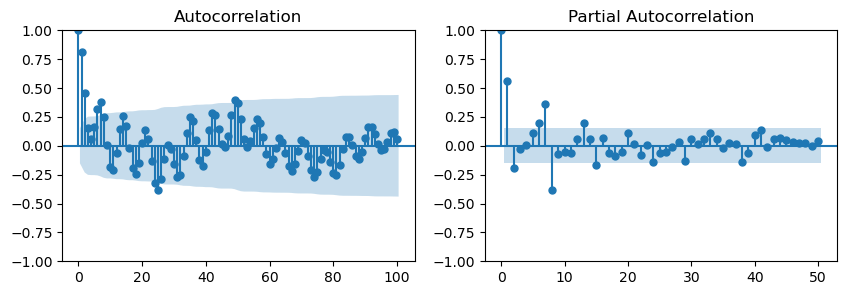

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
sgt.plot_acf(data1["Daily Visitors"],lags=100,ax = ax[0])
sgt.plot_pacf(data["Daily Visitors"],lags=50, ax = ax[1])

plt.show()


In [34]:
#splitting the data
X = data1["Daily Visitors"]
train, test = np.split(X, [int(.80 *len(X))])

In [35]:
train.shape,test.shape

((132,), (34,))

# Model Building

# 1. Holt Winter Model

## Additive Model

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hwe_model_add = ExponentialSmoothing(data1["Daily Visitors"][:132],seasonal="add",trend="add",seasonal_periods=50).fit() #add the trend to the model
predicted_hwe_add = hwe_model_add.predict(start = test.index[0],end = test.index[-1])

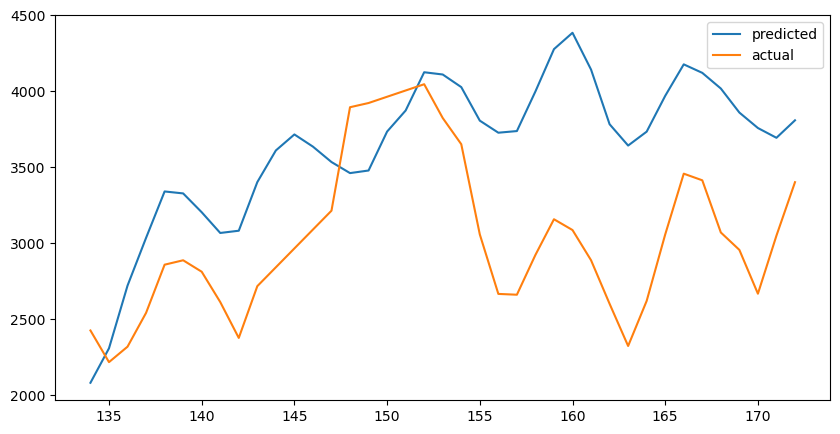

In [37]:
plt.figure(figsize = (10,5))
predicted_hwe_add.plot()
test.plot()
plt.legend(['predicted', 'actual'])
plt.show()

In [38]:
rmse_predicted_hwe_add = np.sqrt(np.abs((test-predicted_hwe_add)**2)).mean()
print("rmse value for HWE_add Model:", rmse_predicted_hwe_add)

rmse value for HWE_add Model: 706.1476720656013


# 2. Holt Winter Method

## Multiplicative Model

In [39]:
hwe_model_mul = ExponentialSmoothing(train,seasonal="mul",trend="mul",seasonal_periods=50).fit() #add the trend to the model
predicted_hwe_mul =hwe_model_mul.predict(start = test.index[0],end = test.index[-1])

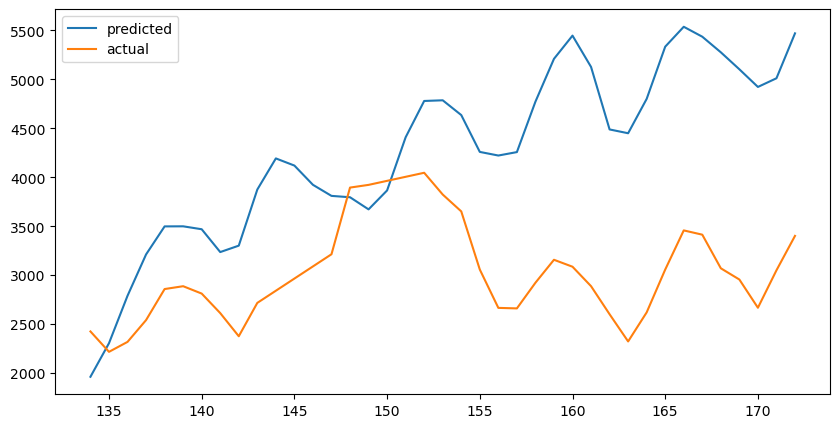

In [40]:
plt.figure(figsize = (10,5))
predicted_hwe_mul.plot()
test.plot()
plt.legend(['predicted', 'actual'])
plt.show()

In [41]:
rmse_predicted_hwe_mul = np.sqrt(np.abs((test-predicted_hwe_mul)**2)).mean()
print("rmse value for HWE_mul Model:", rmse_predicted_hwe_mul)

rmse value for HWE_mul Model: 1352.930544249001


# 3. ARIMA Model

In [42]:
!pip install pmdarima

In [43]:
import pmdarima as pm
model = pm.auto_arima(X, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2267.088, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2321.939, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2277.342, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2271.786, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2320.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2210.903, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2242.153, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2195.068, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2194.035, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2195.008, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2191.594, Time=0.81 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2192.871, Time=0.76 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2174.890, Time=0.85 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2196.969, Time=0.21 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

In [44]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(train,order=(4,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Daily Visitors   No. Observations:                  132
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -853.984
Date:                Thu, 21 Sep 2023   AIC                           1721.967
Time:                        16:48:08   BIC                           1742.094
Sample:                             0   HQIC                          1730.146
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7694      0.084     -9.181      0.000      -0.934      -0.605
ar.L2          0.0281      0.095      0.297      0.766      -0.157       0.213
ar.L3         -0.3731      0.097     -3.852      0.000      -0.563      -0.183
ar.L4         -0.7145      0.066    -10.896      0.000      -0.843      -0.586
ma.L1          1.5122      0.093     16.184      0.000       1.329       1.695
ma.L2          0.7404      0.097      7.653      0.000       0.551       0.930
sigma2        2.6e+04   3553.449      7.318      0.000     1.9e+04     3.3e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.25   Prob(JB):                         0.90
Heteroskedasticity (H):               0.69   Skew:                             0.06
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test RMSE: 578.506


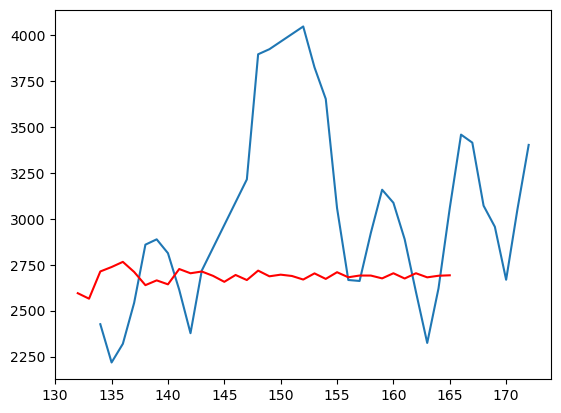

In [45]:
from sklearn.metrics import mean_squared_error
result = model_fit.forecast(len(test))
result = pd.Series(result)
# evaluate forecasts
rmse_ARIMA =np.mean((test-result)**2)**.5
print('Test RMSE: %.3f' % rmse_ARIMA)
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
plt.figure()
plt.plot(test)
plt.plot(result,color = 'red')
plt.show()


# SARIMA Model

In [46]:
import itertools

p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)


In [47]:
import statsmodels.api as sm
sarima_model=sm.tsa.statespace.SARIMAX(data1["Daily Visitors"][:134],order=(2,1,1),seasonal_order=(1,1,1,12))
model=sarima_model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Daily Visitors   No. Observations:                  134
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -816.311
Date:                            Thu, 21 Sep 2023   AIC                           1644.622
Time:                                    16:48:11   BIC                           1661.397
Sample:                                         0   HQIC                          1651.435
                                            - 134                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1106      0.077     14.473      0.000       0.960       1.261
ar.L2         -0.7378      0.064   

In [48]:
forecast = model.get_forecast(steps=12)
predicted_visitors = forecast.predicted_mean
actual_visitors=data1["Daily Visitors"][134:]
rmse_sarima=np.mean((actual_visitors-predicted_visitors)**2)**.5
rmse_sarima

342.38001976208585

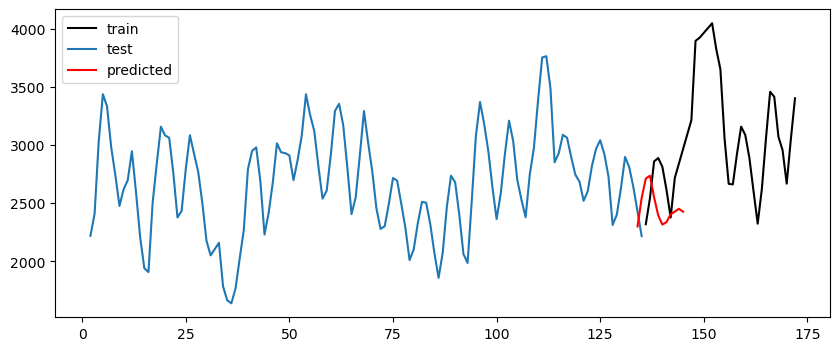

In [49]:
plt.figure(figsize = (10,4))
plt.plot(data1["Daily Visitors"][134:],color='black')
plt.plot(data1["Daily Visitors"][:134])
plt.plot(predicted_visitors, color='red')
plt.legend(['train','test','predicted'])
plt.show()

# LSTM Model

In [50]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pylab import rcParams
from tensorflow import keras


In [59]:
def create_dataset(data1,look_back=1):
    dataX,dataY=[],[]
    for i in range(len(data1)-look_back-1):
        a=data1[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(data1[i+look_back,0])
        
    return np.array(dataX),np.array(dataY)    

In [64]:
model=Sequential()
model.add(LSTM(4,input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(train,test,epochs=100,batch_size=1)

ValueError: Data cardinality is ambiguous:
  x sizes: 132
  y sizes: 34
Make sure all arrays contain the same number of samples.

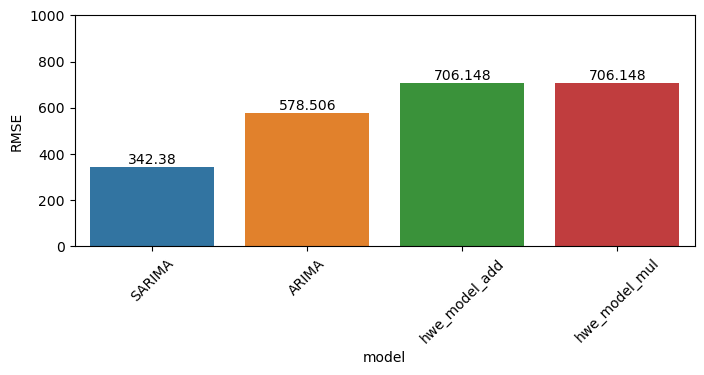

In [50]:
model_evaluation = {'hwe_model_add':rmse_predicted_hwe_add,'hwe_model_mul':rmse_predicted_hwe_add,
                    'ARIMA':rmse_ARIMA,'SARIMA': rmse_sarima}
results = pd.DataFrame(data = model_evaluation, index = range(1)).T.reset_index()
results.columns = ['model','RMSE']
results = results.sort_values(by='RMSE')
plt.figure(figsize=(8,3))
ax = sns.barplot(x = results.model,y=results.RMSE, data=results)
plt.xticks(rotation = 45)
plt.ylim(0,1000)
for i in ax.containers:
    ax.bar_label(i,)